In [8]:
!pip install fuzzywuzzy
!pip install Distance

In [30]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir('/content/gdrive/My Drive/Quora questions pair')
os.listdir()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


['train.csv', 'df_fe_without_preprocessing_train.csv']

In [38]:
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
import distance
import nltk
nltk.download('stopwords')

from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz  #this is for string matching
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [32]:
df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
df = df.fillna('')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


<h2>Preprocessing steps</h2>

* HTML removal
* Remove punctuation
* Do stemming
* Remove stopwords
* Expand contractions

In [33]:
# print(re.sub(r"([0-9]+)000000", r"\1m", "100000000"))
# re.sub(r"([0-9]+)000000", r"\1m", "1000000")
x = "10000000000"
x = re.sub(r"([0-9]+)000000", r"\1m", x)
x = re.sub(r"([0-9]+)000$", r"\1k", x)
print(x)

10000m


In [0]:
def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    
    #here 000000 are replaced with m(million) \1 indicates group1 i.e, the group within paranthesis
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000$", r"\1k", x)#kilo
    
    
    #only if its a string
    if type(x) == type(''):
        #removing html or extracting text from html
        #https://www.crummy.com/software/BeautifulSoup/bs4/doc/
        example1 = BeautifulSoup(x)
        x = example1.get_text()

        #same as [^a-zA-Z0-9_] basically all special chars i think 
        pattern = re.compile('\W')
        #remove them by replacing with ' '
        x = re.sub(pattern, ' ', x)
        
        #word stemmer  
        porter = PorterStemmer()
        x = porter.stem(x)
       
               
    
    return x

<h3>We will create below 15 features :</h3>

w - word
s - stopwords
t - token

* cwc_min : Ratio of common_word_count to min lenghth of word count of Q1 and Q2 
  cwc_min = common_word_count / (min(len(q1_words), len(q2_words))



* cwc_max : Ratio of common_word_count to max lenghth of word count of Q1 and Q2 
 cwc_max = common_word_count / (max(len(q1_words), len(q2_words))



* csc_min : Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 
 csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))



* csc_max : Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2
  csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))



* ctc_min : Ratio of common_token_count to min lenghth of token count of Q1 and Q2
 ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))



* ctc_max : Ratio of common_token_count to max lenghth of token count of Q1 and Q2
 ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))



* last_word_eq : Check if First word of both questions is equal or not
 last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])



* first_word_eq : Check if First word of both questions is equal or not
 first_word_eq = int(q1_tokens[0] == q2_tokens[0])



* abs_len_diff : Abs. length difference
 abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))



* mean_len : Average Token Length of both Questions
 mean_len = (len(q1_tokens) + len(q2_tokens))/2

For below features refer these links on how to compute : 

https://github.com/seatgeek/fuzzywuzzy#usage

https://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

* fuzz_ratio : 

* fuzz_partial_ratio :



* token_sort_ratio : 
* token_set_ratio :
* longest_substr_ratio : Ratio of length longest common substring to min lenghth of token count of   Q1 and Q2
longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))

In [35]:
8/2.0001

3.9998000099994995

In [0]:
STOPWORDS = stopwords.words('english')
def get_token_features(q1,q2):
  """Recieves a pre processedd q1 and q2.creates and returns first 10 features mentioned above"""
  #to store 10 features
  token_features = [0]*10
  
  #now tokenize each question
  q1_token = q1.split()
  q2_token = q2.split()
  
  #if any of the question is empty return 0
  if not len(q1_token) or not len(q2_token):
    return token_features
  
  #getting words(non stopwords)
  q1_words = set([word for word in q1_token if word not in STOPWORDS])
  q2_words = set([word for word in q2_token if word not in STOPWORDS])
  
  #getting only stopwords
  q1_stop = set([word for word in q1_token if word  in STOPWORDS])
  q2_stop = set([word for word in q2_token if word  in STOPWORDS])

  #get common tokens(word+stopword)
  common_word_count = len(q1_words & q2_words)
  common_stop_count = len(q1_stop & q2_stop)
  common_token_count = len(set(q1_token) & set(q2_token))
  q1_word_len,q2_word_len = len(q1_words),len(q2_words)
  q1_stop_len,q2_stop_len = len(q1_stop),len(q2_stop)
  q1_token_len,q2_token_len = len(q1_token),len(q2_token)
  #this is to avoid divide by zero error
  SAFEDIV = 0.0001
  token_features[0] = common_word_count / (min(q1_word_len,q2_word_len)+SAFEDIV)
  token_features[1] = common_word_count / (max(q1_word_len,q2_word_len )+SAFEDIV)
  token_features[2] = common_stop_count / (min(q1_stop_len,q2_stop_len)+SAFEDIV)
  token_features[3] = common_stop_count / (max(q1_stop_len,q2_stop_len)+SAFEDIV)
  token_features[4] = common_token_count / (min(q1_token_len,q2_token_len)+SAFEDIV)
  token_features[5] = common_token_count / (max(q1_token_len,q2_token_len)+SAFEDIV)
  #last word eq
  token_features[6] = int(q1_token[-1] == q2_token[-1])
  #first word eq
  token_features[7] = int(q1_token[0] == q2_token[0])
  #abs diff len
  token_features[8] = abs(len(q1_token)-len(q2_token))
  #mean len
  token_features[9] = (len(q1_token)+len(q2_token))/2
  
  return token_features


def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

      
def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print('Preprocessing done')    
    # Adding the new computed Features to df
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    #mapping each feature(column) into their respective series in the dataframe
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
  

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [42]:
try:
    df = pd.read_csv("nlp_features_train.csv")
except:
    df = pd.read_csv("train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


Preprocessing done


,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0,1,2,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0,1,5,12.5,86,63,66,75,0.596154


In [45]:
df.corr()['is_duplicate']

id                     -0.008784
qid1                   -0.247072
qid2                   -0.260101
is_duplicate            1.000000
cwc_min                 0.401610
cwc_max                 0.407591
csc_min                 0.215693
csc_max                 0.215954
ctc_min                 0.365847
ctc_max                 0.355109
last_word_eq            0.306007
first_word_eq           0.204783
abs_len_diff           -0.203532
mean_len               -0.188996
token_set_ratio         0.398052
token_sort_ratio        0.382879
fuzz_ratio              0.384997
fuzz_partial_ratio      0.360933
longest_substr_ratio    0.264757
Name: is_duplicate, dtype: float64

<h2>Word clouds of duplicate and non duplicate </h2>

In [66]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [69]:
textp_w = open('train_p.txt').read()
textn_w = open('train_n.txt').read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
#not no like has significant meaning as we found out during Amazon Fine FOod so we arent gonna use then as stopwords
stopwords.remove("not")

stopwords.remove("no")

print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16129074
Total number of words in non duplicate pair questions : 33196476


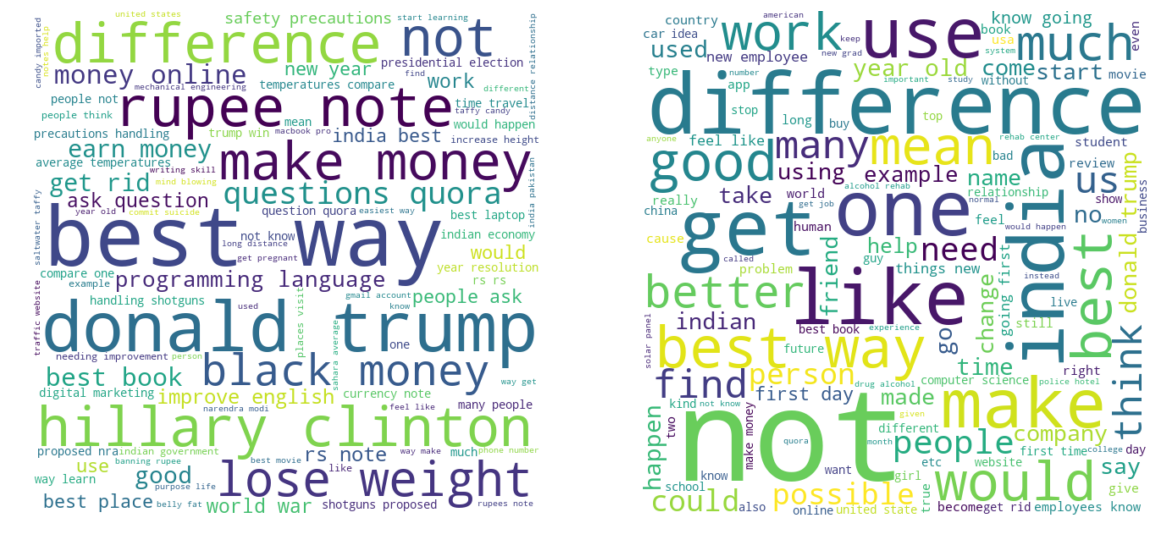

In [78]:
#duplicate word cloud
wordcloud1 = WordCloud(width = 600, height = 600, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(textp_w) 

#nonduplicate word cloud
wordcloud2 = WordCloud(width = 600, height = 600, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(textn_w)
  
# plot the WordCloud image                        
plt.figure(figsize = (20, 20)) 
plt.subplot(1,2,1)
plt.imshow(wordcloud1,interpolation="bilinear") 
plt.axis("off") 
plt.subplot(1,2,2)
plt.imshow(wordcloud2,interpolation="bilinear") 
plt.axis("off")
plt.show() 

 

<h2>Bivariate analysis</h2>

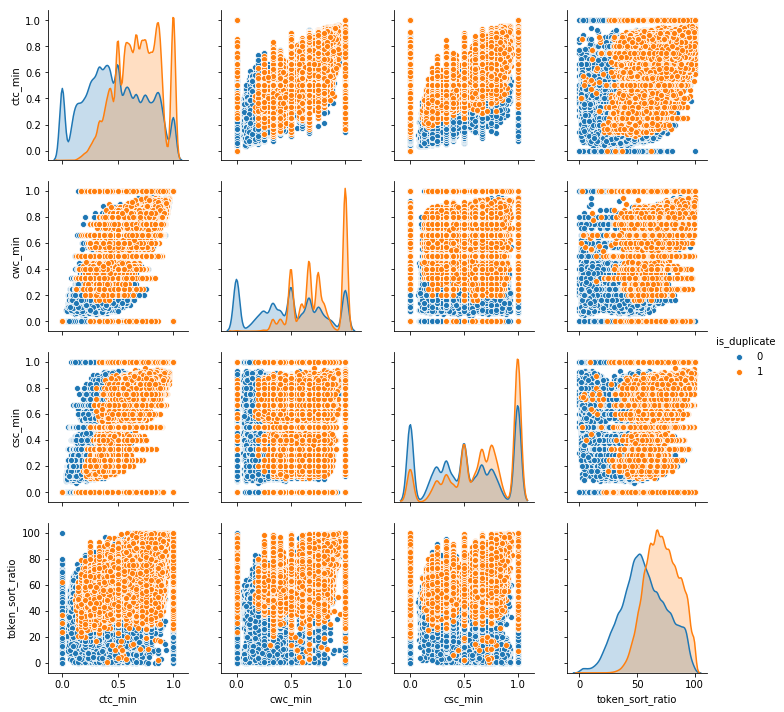

In [80]:
n = df.shape[0]

import seaborn as sns

sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

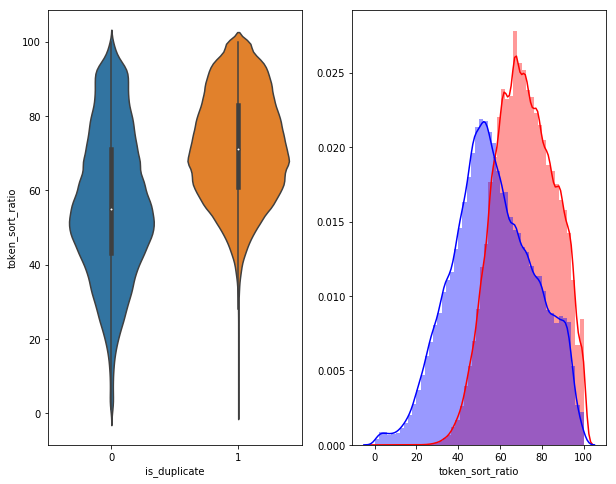

In [81]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

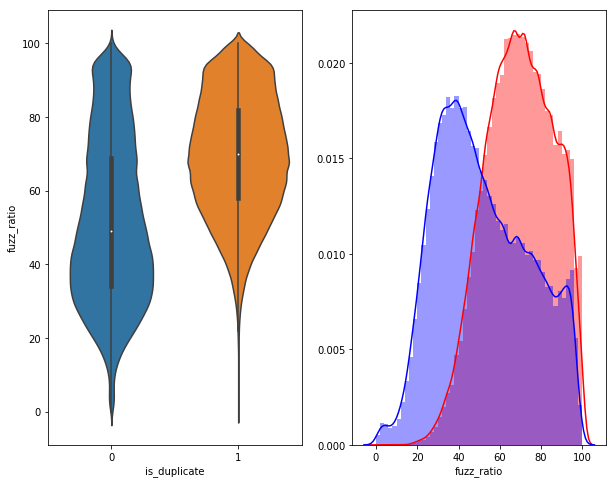

In [82]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

<h2>Visualizing using TSNE</h2>
we can use tsne to project d-dim data onto desired(here 2)

In [83]:

from sklearn.preprocessing import MinMaxScaler
#because of computational restriction only using sample of it
dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [84]:
tsne2d = TSNE(
    n_components=2,
    init='random',
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.014s...
[t-SNE] Computed neighbors for 5000 samples in 0.376s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.131969
[t-SNE] Computed conditional probabilities in 0.319s
[t-SNE] Iteration 50: error = 81.2723770, gradient norm = 0.0473952 (50 iterations in 2.929s)
[t-SNE] Iteration 100: error = 70.6811676, gradient norm = 0.0098449 (50 iterations in 2.107s)
[t-SNE] Iteration 150: error = 68.9724045, gradient norm = 0.0055368 (50 iterations in 1.997s)
[t-SNE] Iteration 200: error = 68.1879044, gradient norm = 0.0042483 (50 iterations in 2.053s)
[t-SNE] Iteration 250: error = 67.6987152, gradient norm = 0.0032788

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


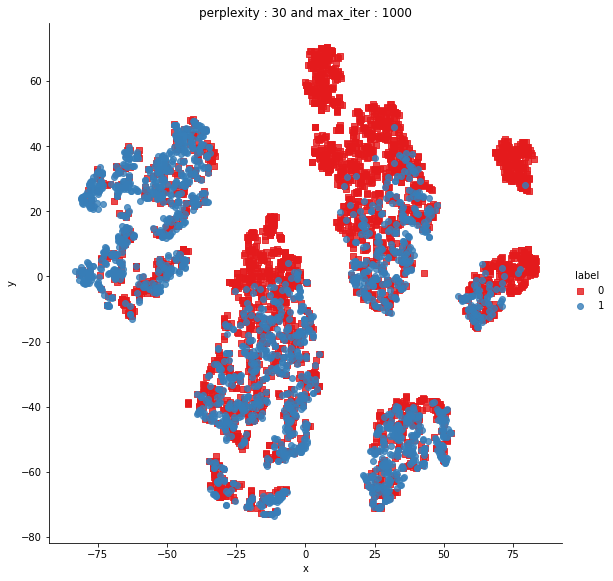

In [85]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

<h2>Vectorizing with tfidf weighted word vectors</h2>

Because we know some words occur more often than others especially words occur at different frequenc